# Machine Learning: Unsupervised Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We Use the Cumulative Database of Objects of Interest of the Kepler Exoplanet Observatory at https://exoplanetarchive.ipac.caltech.edu/docs/data.html

In this notebook we implement the K-means algoritm to classify the CONFIRMED planetary objects of the database as functions of their radii and periods.

In [2]:
# Load the exoplanet database
data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_disposition,koi_period,koi_prad&format=csv"
df_kepler = pd.read_csv(data_url)

Drop All NaNs

In [3]:
df_kepler_clean=df_kepler.dropna().reset_index(drop=True)
df_kepler_clean

,koi_disposition,koi_period,koi_prad
0,CONFIRMED,9.488036,2.26
1,CONFIRMED,54.418383,2.83
2,CANDIDATE,19.899140,14.60
3,FALSE POSITIVE,1.736952,33.46
4,CONFIRMED,2.525592,2.75
...,...,...,...
9196,FALSE POSITIVE,0.527699,29.35
9197,CANDIDATE,1.739849,0.72
9198,FALSE POSITIVE,0.681402,1.07
9199,CANDIDATE,333.486169,19.30


## Filtering

In [11]:
def filter(df,col,iqr_score):
  iqr_col=df[col].quantile(0.75)-df[col].quantile(0.25)
  filter_lower=df[col]>df[col].quantile(0.25)-(iqr_col*iqr_score)
  filter_upper=df[col]<df[col].quantile(0.75)+(iqr_col*iqr_score)
  return df[filter_lower & filter_upper]

In [12]:
df_k1=filter(df_kepler_clean,'koi_prad',2)
df_k2=filter(df_k1,'koi_period',2)

We keep only CONFIRMED planets

In [13]:
df=df_k2[df_k2['koi_disposition']=='CONFIRMED'].reset_index(drop=True)

In [15]:
df.shape

(2603, 3)

<Axes: xlabel='Planet Period (Days)', ylabel='Planet Radius (Earth Radii)'>

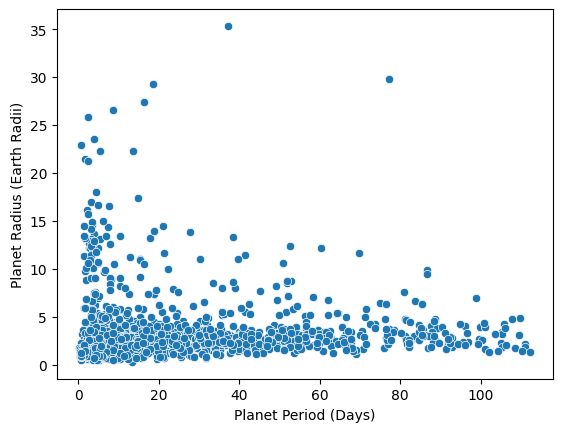

In [16]:
fig=plt.figure()
ax= fig.add_subplot()
ax.set_xlabel('Planet Period (Days)')
ax.set_ylabel('Planet Radius (Earth Radii)')
sns.scatterplot(x=df['koi_period'],y=df['koi_prad'],ax=ax)

## Elbow Method: Determination of the Number of Clusters

In [17]:
from sklearn.cluster import KMeans

In [21]:
inertia=[]
for n in range(1,8):
  model= KMeans(n_clusters=n, init='k-means++',n_init=10)
  model.fit(df[['koi_period','koi_prad']])
  inertia.append(model.inertia_)

Text(0, 0.5, 'Inertia')

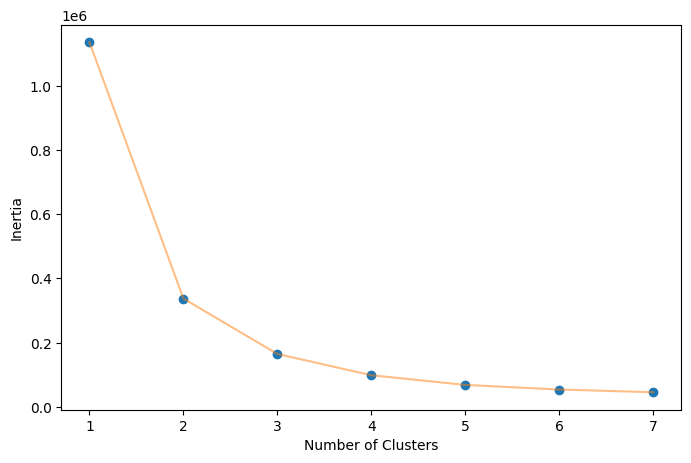

In [22]:
plt.figure(1,figsize=(8,5))
plt.plot(np.arange(1,8),inertia, 'o')
plt.plot(np.arange(1,8),inertia, '-',alpha=0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

This plot shows that the inertia has an almost linear behavior starting with 3 clusters. Thus we adopt this value for the classification.

In [32]:
km=KMeans(n_clusters=3, init='k-means++',n_init=10)
km.fit(df[['koi_period','koi_prad']])

KMeans(n_clusters=3, n_init=10)

In [33]:
centers=km.cluster_centers_
centers

array([[ 8.57493353,  2.5253681 ],
       [81.02832744,  3.47603774],
       [36.37862699,  2.96581967]])

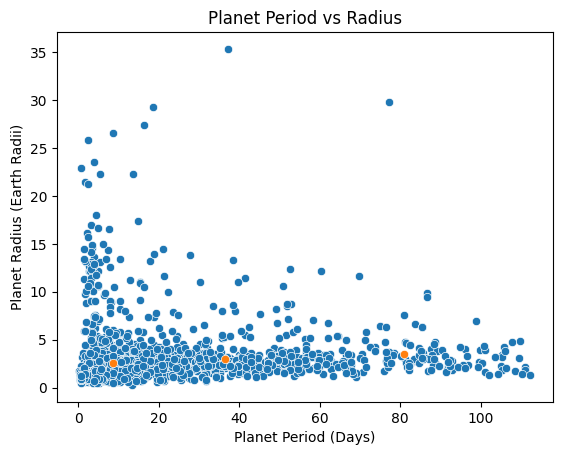

In [43]:
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Planet Period vs Radius')
ax.set_xlabel('Planet Period (Days)')
ax.set_ylabel('Planet Radius (Earth Radii)')
sns.scatterplot(x=df['koi_period'],y=df['koi_prad'],ax=ax)
sns.scatterplot(x=centers[:,0],y=centers[:,1],ax=ax)
plt.show()

Now we can identify to which class each planet belongs

In [35]:
classification=km.predict(df[['koi_period','koi_prad']])

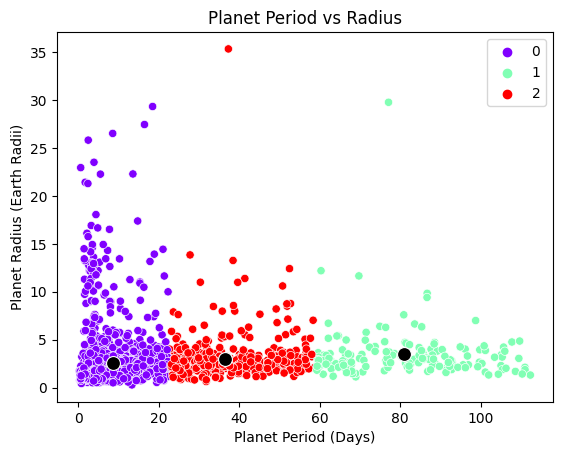

In [44]:
fig=plt.figure()
ax=fig.add_subplot()
ax.set_title('Planet Period vs Radius')
ax.set_xlabel('Planet Period (Days)')
ax.set_ylabel('Planet Radius (Earth Radii)')
sns.scatterplot(x=df['koi_period'],y=df['koi_prad'],ax=ax,hue=classification,
                palette='rainbow')
sns.scatterplot(x=centers[:,0],y=centers[:,1],ax=ax,s=100,color='black')
plt.show()

Thus, it seems that a natural classification of exoplanets in terms of its radius and period is dominated by the period, which in this case was split by K-means in three regions: Small Period (Class 0), Large Period (Class 1) and Medium Period (Class 2). Besides, the algorithm identifies that the centroid of each class has small radius. We now visualize the marginal probability densities for each group.

In [45]:
df['class']=classification

In [46]:
group_0=df[df['class']==0]
group_1=df[df['class']==1]
group_2=df[df['class']==2]

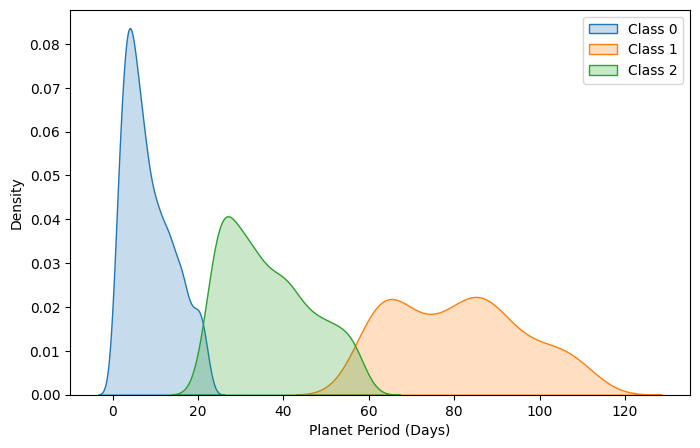

In [48]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot()
sns.kdeplot(data=group_0,x='koi_period',ax=ax,label='Class 0', fill=True)
sns.kdeplot(data=group_1,x='koi_period',ax=ax,label='Class 1', fill=True)
sns.kdeplot(data=group_2,x='koi_period',ax=ax,label='Class 2', fill=True)
ax.set_xlabel('Planet Period (Days)')
ax.set_ylabel('Density')
ax.legend()

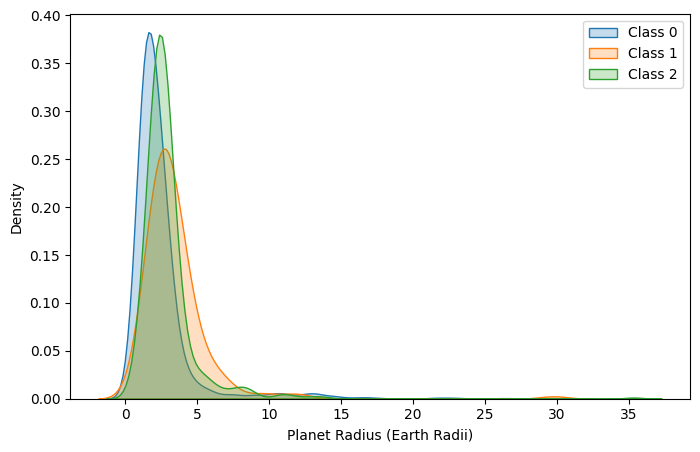

In [50]:
fig=plt.figure(figsize=(8,5))
ax=fig.add_subplot()
sns.kdeplot(data=group_0,x='koi_prad',ax=ax,label='Class 0', fill=True)
sns.kdeplot(data=group_1,x='koi_prad',ax=ax,label='Class 1', fill=True)
sns.kdeplot(data=group_2,x='koi_prad',ax=ax,label='Class 2', fill=True)
ax.set_xlabel('Planet Radius (Earth Radii)')
ax.set_ylabel('Density')
ax.legend()